# Apply clustering to Shalek2013 and Macaulay2016 data



In [2]:
# Baked-in within python modules
from collections import defaultdict

# Alphabetical order for nonstandard python modules is conventional
# We're doing "import superlongname as abbrev" for our laziness - this way we don't have to type out the whole thing each time.

# Python plotting library
import matplotlib as mpl
import matplotlib.pyplot as plt

# Numerical python library (pronounced "num-pie")
import numpy as np

# Dataframes in Python
import pandas as pd

# T-test of independent samples
from scipy.stats import ttest_ind

# Statistical plotting library we'll use
import seaborn as sns
sns.set(style='whitegrid')

# Matrix decomposition
from sklearn.decomposition import PCA, FastICA

# Manifold learning
from sklearn.manifold import MDS, TSNE

# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans

# Plotting dendrograms
from scipy.cluster import hierarchy

# This is necessary to show the plotted figures inside the notebook -- "inline" with the notebook cells
%matplotlib inline

## Shalek2013 data



In [3]:
shalek2013_metadata = pd.read_csv('../data/shalek2013/metadata.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
shalek2013_expression = pd.read_csv('../data/shalek2013/expression.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)
shalek2013_expression_feature = pd.read_csv('../data/shalek2013/expression_feature.csv', 
                               
                                     # Sets the first (Python starts counting from 0 not 1) column as the row names
                                      index_col=0)

In [4]:
shalek2013_metadata['color'] = shalek2013_metadata['maturity'].map(
    lambda x: 'MediumTurquoise' if x == 'immature' else 'Teal')
shalek2013_metadata.loc[shalek2013_metadata['pooled'], 'color'] = 'black'
shalek2013_metadata

,phenotype,pooled,outlier,maturity,color
S1,BDMC,False,False,immature,MediumTurquoise
S2,BDMC,False,False,immature,MediumTurquoise
S3,BDMC,False,False,immature,MediumTurquoise
S4,BDMC,False,False,immature,MediumTurquoise
S5,BDMC,False,False,immature,MediumTurquoise
S6,BDMC,False,False,immature,MediumTurquoise
S7,BDMC,False,False,immature,MediumTurquoise
S8,BDMC,False,False,immature,MediumTurquoise
S9,BDMC,False,False,immature,MediumTurquoise
S10,BDMC,False,False,immature,MediumTurquoise


If you specify "`n_components=None`", then the program will find as many components as there are samples.

In [5]:
shalek2013_smusher = PCA(n_components=None)
shalek2013_smushed = pd.DataFrame(shalek2013_smusher.fit_transform(shalek2013_expression), 
                                  index=shalek2013_expression.index)
print(shalek2013_smushed.shape)
shalek2013_smushed.head()

(21, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
S1,-47.162601,9.425470,-15.905578,30.728110,30.341425,-14.614850,-20.772214,-18.237198,-43.387923,59.417222,...,45.602970,17.272361,12.588817,13.176885,35.224227,-20.575902,-4.897768,0.035161,-0.021331,3.231729e-14
S2,28.941488,25.678547,-49.181067,7.955534,3.323696,76.363303,1.972781,-51.830222,44.170453,33.715913,...,-8.316688,-0.321535,-32.995952,-15.603800,2.050265,-4.029456,0.204415,-0.039399,-0.060018,3.231729e-14
S3,8.054771,33.133762,33.695133,16.340005,-29.997176,3.389761,12.349274,-24.559213,18.710579,-8.633149,...,40.663989,26.146938,38.567858,-21.577151,-12.108372,68.643203,9.483584,-0.021501,-0.024996,3.231729e-14
S4,20.693003,42.692214,17.625862,-11.614830,-23.509632,-7.453328,7.273635,-8.338267,-5.441408,-28.580672,...,-7.052002,-29.679637,-31.118982,40.480245,79.846959,19.599450,14.787919,-0.005931,-0.002908,3.231729e-14
S5,0.525987,29.102877,18.513061,15.065190,-28.733401,-19.812431,-14.067554,-17.832859,-32.811782,-9.427815,...,27.972299,-29.581119,-63.739590,6.399915,-62.920949,-11.701652,12.789166,-0.033147,0.001494,3.231729e-14


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


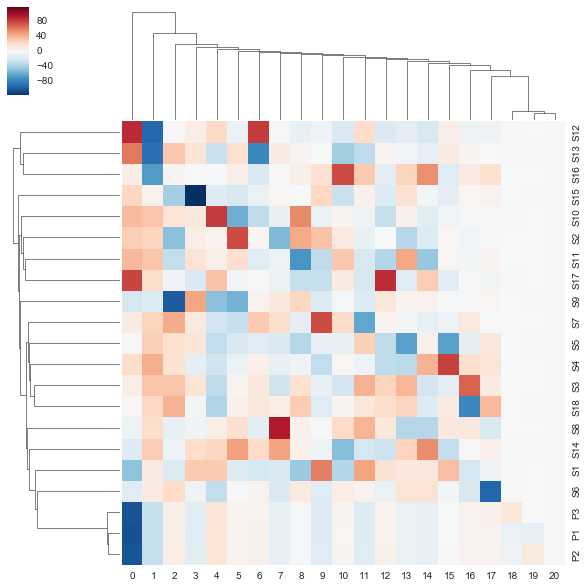

In [6]:
g = sns.clustermap(shalek2013_smushed)

We can add the colors of the samples as the rows, the "MediumTurqouise" (lighter) for the immature cells, "Teal" (darker) for the mature cells, and black for the pooled samples.

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


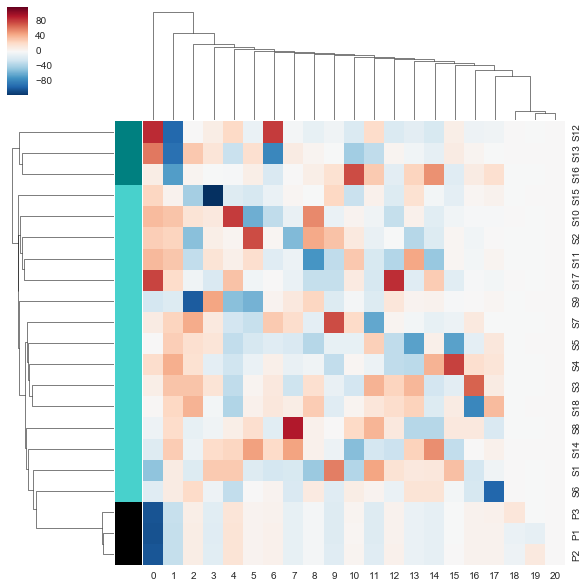

In [7]:
g = sns.clustermap(shalek2013_smushed, row_colors=shalek2013_metadata['color'])

We can use different distance metrics, too. Here we're using `"cityblock"` (instead of the default `"euclidean"`)

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


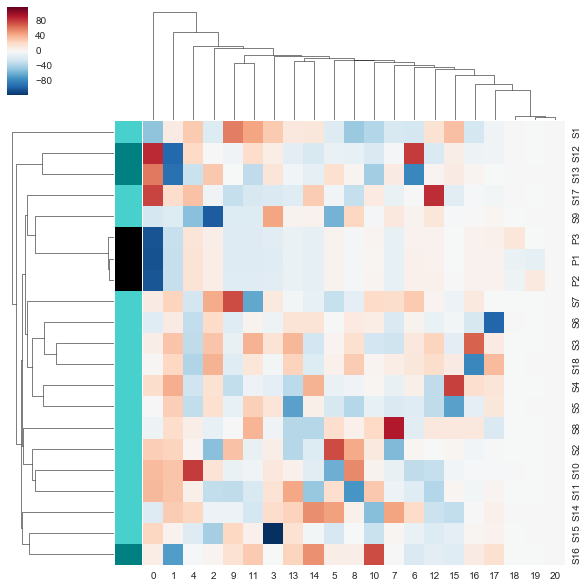

In [8]:
g = sns.clustermap(shalek2013_smushed, metric='cityblock', row_colors=shalek2013_metadata['color'])

Or different distance linkage methods. Here we're using `"ward"` (instead of the default `"average"`)

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


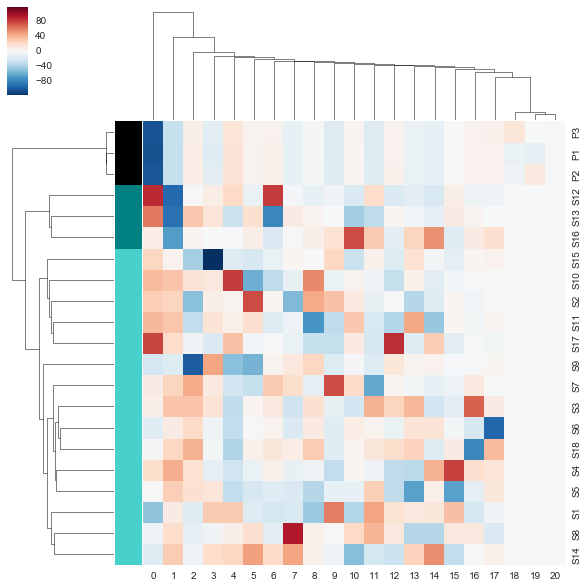

In [9]:
g = sns.clustermap(shalek2013_smushed, method='ward', row_colors=shalek2013_metadata['color'])

You can combine methods and metrics as well:

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


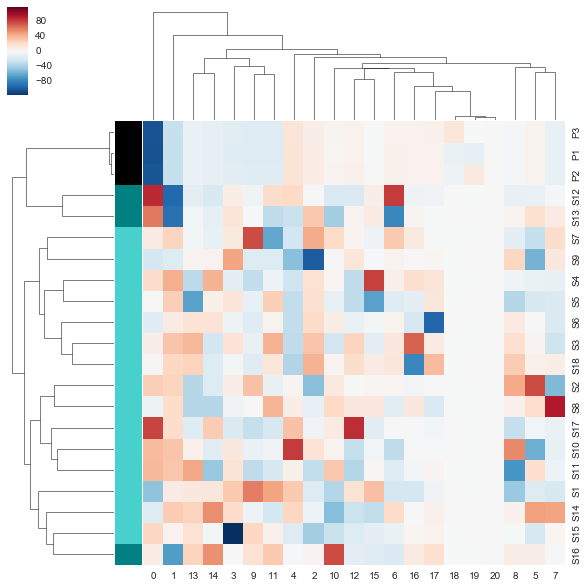

In [10]:
g = sns.clustermap(shalek2013_smushed, method='ward', metric='cityblock', row_colors=shalek2013_metadata['color'])

### Exercise 1

1. Try using different numbers of components with PCA. What's the minimum number of components to separate out the pooled and singles, and find a subset of three cells in the singles? (like in the paper!)
2. Try using ICA instead of PCA. 
    1. What happens when you do `n_components=None`? Why?
    

### Retreive cluster assignments from hierarchical clustering

We used 

(21, 5)


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


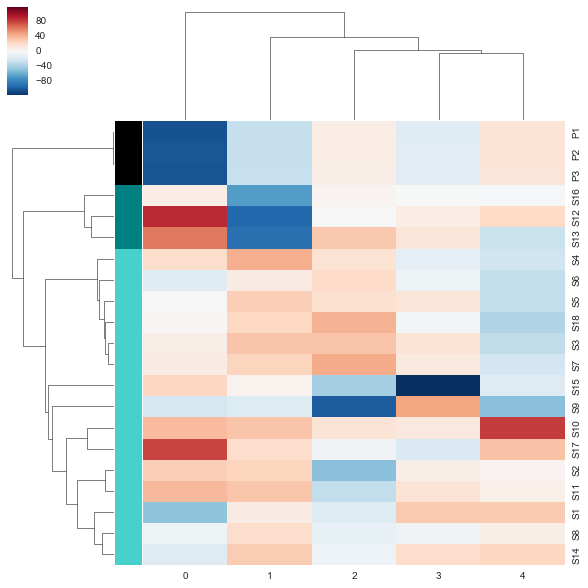

In [11]:
shalek2013_smusher = PCA(n_components=5)
shalek2013_smushed = pd.DataFrame(shalek2013_smusher.fit_transform(shalek2013_expression), 
                                  index=shalek2013_expression.index)
print(shalek2013_smushed.shape)
g = sns.clustermap(shalek2013_smushed, method='ward', metric='euclidean', 
                   row_colors=shalek2013_metadata['color'])

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


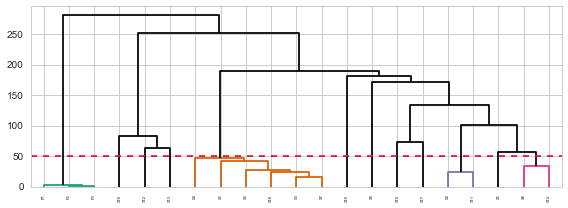

In [12]:
figwidth, figheight = 8, 3
fig, ax = plt.subplots(figsize=(figwidth, figheight))

# Make the clustering dendrogram colors not suck
hierarchy.set_link_color_palette(list(map(mpl.colors.rgb2hex, sns.color_palette('Dark2', n_colors=12))))

cluster_threshold = 50

cden = hierarchy.dendrogram(g.dendrogram_row.linkage, 
                            color_threshold=cluster_threshold, 
                            labels=shalek2013_expression.index,
                            above_threshold_color='k')
plt.axhline(cluster_threshold, color='Crimson', linestyle='--');
plt.xticks(rotation=90, fontsize=4);

Here's a utility function to get the cluster class assignments after thresholding

In [13]:
"""
Cluster assignment and coloring functions from Macaulay supplemental notebooks
"""

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = mpl.colors.rgb2hex(mpl.colors.colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = list(sorted([den[label][i] for i in l]))
        cluster_classes[c] = i_l

    return cluster_classes

def get_cluster_limits(den):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_limits = Clusters()
    for c in cluster_idxs:
        cluster_limits[c] = (min(cluster_idxs[c]), max(cluster_idxs[c]))
    
    return cluster_limits

In [14]:
# --- Get cluster-defined colors for each cell, for this threshold --- #
clusters = get_cluster_classes(cden)
cluster_cell_colors = []
for cell in shalek2013_expression.index:
    for color in clusters:
        if cell in clusters[color]:
            cluster_cell_colors.append(color)
            break
cluster_cell_colors

['k',
 '#7570b3',
 '#d76003',
 '#d76003',
 '#d76003',
 '#d76003',
 '#d76003',
 '#e62a8a',
 'k',
 'k',
 '#7570b3',
 'k',
 'k',
 '#e62a8a',
 'k',
 'k',
 'k',
 '#d76003',
 '#1b9e77',
 '#1b9e77',
 '#1b9e77']

Re-plot the clustered heatmap with the samples colored by clusters

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


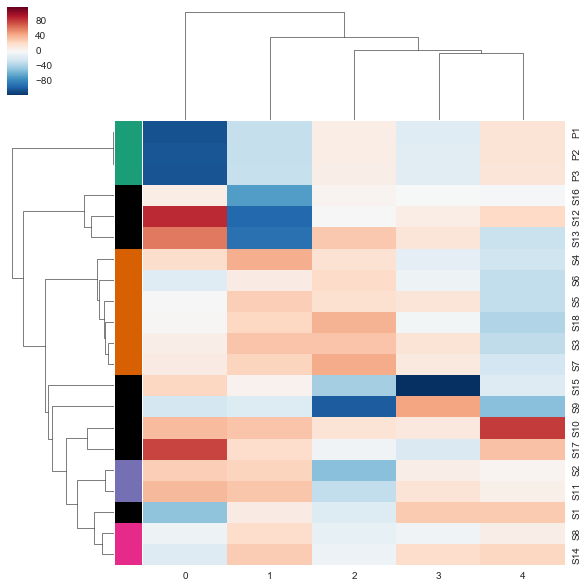

In [15]:
g = sns.clustermap(shalek2013_smushed, method='ward', metric='euclidean', 
                   row_colors=cluster_cell_colors)

Plot the first two components of the PCA with the cells colored by the cluster classes

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


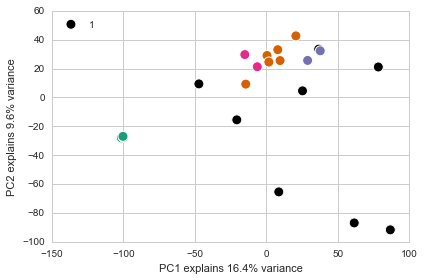

In [16]:
# Initialize a figure with a single subpanel (axes, or ax) to plot on
fig, ax = plt.subplots()


# Plot the first ("0") and second ("1") components
ax.scatter(shalek2013_smushed[0], shalek2013_smushed[1], color=cluster_cell_colors, 
           s=100, edgecolor='white', linewidth=1)

xlabel = 'PC1 explains {:.1f}% variance'.format(100*shalek2013_smusher.explained_variance_ratio_[0])
ylabel = 'PC2 explains {:.1f}% variance'.format(100*shalek2013_smusher.explained_variance_ratio_[1])

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# Force legend location to be upper left
ax.legend(loc='upper left')

### Exercise 2

1. Try different cluster cutoff threshold values.
2. Try different linkage methods and distance metrics.
    1. How does that change the threshold you use?
    2. How does it change the final clustering groups?
3. Try ICA, and try out different linkage methods and distance metrics.
    1. How does that change the threshold you use?
    2. How does it change the final clustering groups?

### $K$-means clustering

We'll perform K-means clustering on the original expression matrix, and then plot the PCA of the data with the clusters labled.

In [17]:
from sklearn.cluster import KMeans
n_clusters = 5

estimator = KMeans(n_clusters)
estimator.fit(shalek2013_expression)
kmeans_clusters = estimator.predict(shalek2013_expression)
kmeans_clusters


array([2, 3, 4, 3, 3, 4, 4, 1, 2, 3, 3, 0, 0, 1, 3, 4, 3, 4, 2, 2, 2], dtype=int32)

In [18]:
kmeans_palette = sns.color_palette('Set2', n_colors=n_clusters)
kmeans_colors = [kmeans_palette[i] for i in kmeans_clusters]

Project the cluster centers into reduced dimensionality space

In [19]:
estimator.cluster_centers_

array([[ 0.05523477,  1.6979426 ,  2.26801523, ...,  0.12644955,
         6.49030727,  2.05303709],
       [ 2.37810567,  2.52227951,  1.04455084, ...,  4.08410371,
         6.97892931,  2.25861684],
       [ 2.25668834,  3.28095773,  0.75053224, ...,  2.45192369,
         6.76114002,  4.7502008 ],
       [ 0.04237619,  1.63767421,  1.24868719, ...,  2.51697477,
         7.0193053 ,  1.66573555],
       [ 1.95935666,  2.25619227,  1.5785239 , ...,  1.08041248,
         6.11188894,  1.35377397]])

In [20]:
cluster_centers = pd.DataFrame(shalek2013_smusher.fit_transform(estimator.cluster_centers_))
cluster_centers

,0,1,2,3,4
0,-108.683319,-8.156916,22.629649,-0.345913,2.085367e-14
1,44.298331,58.014912,37.618429,4.102192,2.085367e-14
2,54.333169,-62.929203,21.433522,-10.611081,2.085367e-14
3,0.849566,18.871281,-45.510535,-35.214866,2.085367e-14
4,9.202254,-5.800073,-36.171065,42.069668,2.085367e-14


Plot the PCA-reduced data with the cluster columns, and the cluster centers as a black "X", using the "

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


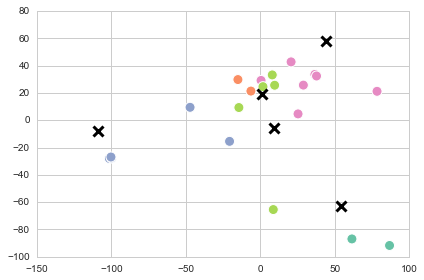

In [21]:
plt.scatter(shalek2013_smushed[0], shalek2013_smushed[1], color=kmeans_colors,
            s=100, edgecolor='white', linewidth=1);
plt.scatter(cluster_centers[0], cluster_centers[1], color='k', marker='x', s=100, linewidth=3)

### Exercise 3

Try different numbers of clusters. Can you get the pooled, mature, and immature cells as separate clusters? Why or why not?


## Macaulay2016

Read in and filter the macaulay2016 data

In [22]:
macaulay2016_expression = pd.read_csv('../data/macaulay2016/gene_expression_s.csv', index_col=0)


# Set maximum columns to display as 50 because the dataframe has 49 columns
pd.options.display.max_columns = 50

macaulay2016_metadata = pd.read_csv('../data/macaulay2016/sample_info_qc.csv', index_col=0)
# Add column for gfp
macaulay2016_metadata['gfp_color'] = ['#31a354' if c == 'HIGH' else '#e5f5e0' for c in macaulay2016_metadata['condition']]

# Necessary step for converting the parsed cluster color to be usable with matplotlib
macaulay2016_metadata['cluster_color'] = macaulay2016_metadata['cluster_color'].map(eval)

# --- Filter macaulay2016 data --- #
ensembl_genes = [x for x in macaulay2016_expression.index if x.startswith('ENS')]
cells_pass_qc = macaulay2016_metadata["Pass QC"].index[macaulay2016_metadata["Pass QC"]]

macaulay2016_expression_filtered = macaulay2016_expression.loc[ensembl_genes, cells_pass_qc]

# Recalculate TPM
macaulay2016_expression_filtered = 1e6 * macaulay2016_expression_filtered / macaulay2016_expression_filtered.sum()

# Transpose so it's machine learning format
macaulay2016_expression_filtered = macaulay2016_expression_filtered.T

# Take only "expressed genes" with expression greater than 1 in at least 3 cells
mask = (macaulay2016_expression_filtered > 1).sum() >= 3
macaulay2016_expression_filtered = macaulay2016_expression_filtered.loc[:, mask]
print('macaulay2016_expression_filtered.shape', macaulay2016_expression_filtered.shape)

# Add 1 and log10
macaulay2016_expression_log10 = np.log10(macaulay2016_expression_filtered + 1)

# Macaulay2016 plotting colors
macaulay2016_gfp_colors = macaulay2016_metadata.loc[macaulay2016_expression_log10.index, 'gfp_color']

# Get cluster colors from the paper
macaulay2016_cluster_colors_from_paper = macaulay2016_metadata.loc[macaulay2016_expression_log10.index, 'cluster_color']
macaulay2016_clusters_from_paper = macaulay2016_metadata.loc[macaulay2016_expression_log10.index, 'cluster']
macaulay2016_cluster_to_color_from_paper = dict(zip(macaulay2016_clusters_from_paper, macaulay2016_cluster_colors_from_paper))

macaulay2016_expression_filtered.shape (363, 20672)


Plot the Macaulay data. We'll call the PCA or ICA reduced data `macaulay2016_decomposer` because we'll use t-SNE later and we want to distinguish from when we're using matrix decomposition vs manifold learning.

(363, 10)


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


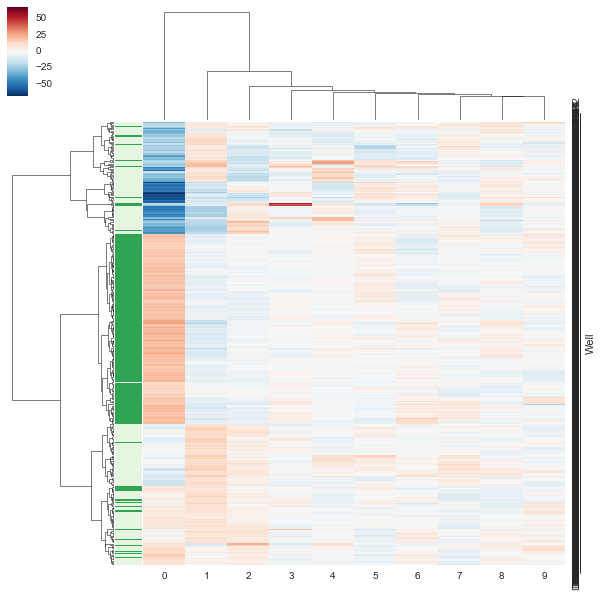

In [23]:
macaulay2016_decomposer = PCA(n_components=10)
macaulay2016_decomposed = pd.DataFrame(macaulay2016_decomposer.fit_transform(macaulay2016_expression_log10), 
                                  index=macaulay2016_expression_log10.index)
print(macaulay2016_decomposed.shape)
g = sns.clustermap(macaulay2016_decomposed, method='ward', metric='euclidean', 
                   row_colors=macaulay2016_gfp_colors)

We can also color the rows by the actual clusters from the paper.

(363, 10)


/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


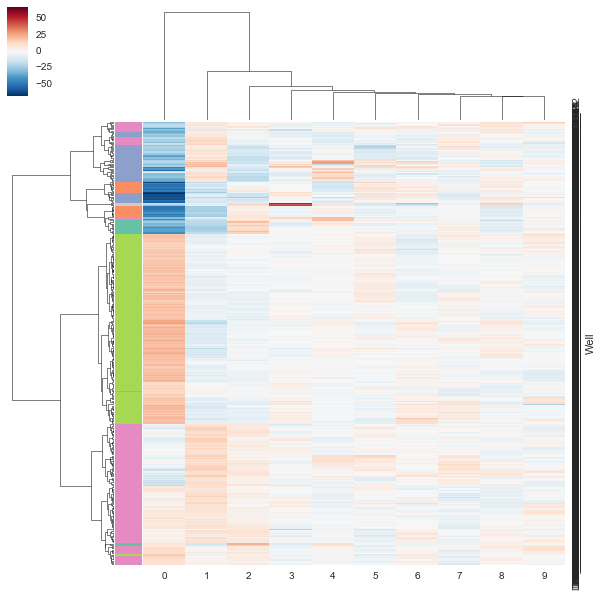

In [24]:
macaulay2016_decomposer = PCA(n_components=10)
macaulay2016_decomposed = pd.DataFrame(macaulay2016_decomposer.fit_transform(macaulay2016_expression_log10), 
                                  index=macaulay2016_expression_log10.index)
print(macaulay2016_decomposed.shape)
g = sns.clustermap(macaulay2016_decomposed, method='ward', metric='euclidean', 
                   row_colors=macaulay2016_cluster_colors_from_paper)

### Exercise 4

Use hierarchical clustering on either PCA or ICA to assign clusters to the Macaulay data and plot the PCA (or ICA) plot with the reduced clusters. Are you able to recover the original clusters? Use as many code cells as you need.

In [25]:
# YOUR CODE HERE

In [26]:
# YOUR CODE HERE

In [27]:
# YOUR CODE HERE

### Exercise 5: $K$-means on Macaulay data

Use K-means clustering to assign clusters to the Macaulay data and plot the PCA (or ICA) plot with the reduced clusters. Are you able to recover the original clusters? Use as many code cells as you need.

In [28]:
# YOUR CODE HERE

In [29]:
# YOUR CODE HERE

In [30]:
# YOUR CODE HERE

### Clustering + visualizing using manifold learning

Now we'll get closer to the actual steps used in the Macaulay2016 paper.

/Users/olga/anaconda3/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


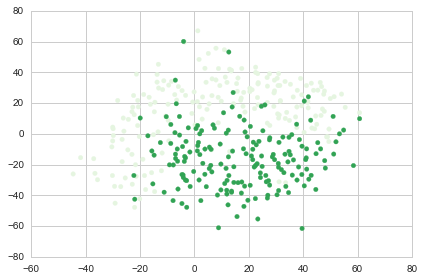

In [31]:
macaulay2016_decomposer = FastICA(n_components=10, random_state=3984)
macaulay2016_decomposed = pd.DataFrame(macaulay2016_decomposer.fit_transform(macaulay2016_expression_log10), 
                                  index=macaulay2016_expression_log10.index)
macaulay2016_tsne_smusher = TSNE(n_components=2, random_state=254)
macaulay2016_tsne_smushed = pd.DataFrame(macaulay2016_tsne_smusher.fit_transform(macaulay2016_decomposed),
                                         index=macaulay2016_expression_log10.index)

fig, ax = plt.subplots()
ax.scatter(macaulay2016_tsne_smushed[0], macaulay2016_tsne_smushed[1],
           color=macaulay2016_gfp_colors)

### Exercise 6: Cluster and visualize on t-SNE

Use hierarchical clustering on ICA-decomposed data (trying different numbers of components) to assign clusters, and plot the cluster assignments on the t-SNE reduced data. Use as many code cells as you need.

In [32]:
# YOUR CODE HERE

In [33]:
# YOUR CODE HERE

In [34]:
# YOUR CODE HERE